In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('/content/baseline_model_metrics(X).csv')

In [3]:
df = pd.read_csv('/content/baseline_model_metrics(Y).csv')

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# --- FIX: Define X and y from the respective CSV files ---
X = pd.read_csv('/content/baseline_model_metrics(X).csv')
y = pd.read_csv('/content/baseline_model_metrics(Y).csv').squeeze() # Assuming Y is a single column target
# --- End of FIX ---

# --- FIX: Apply one-hot encoding to categorical features in X before splitting ---
# Identify categorical columns (object dtype) in the full X dataset
categorical_cols = X.select_dtypes(include='object').columns

# Apply one-hot encoding
X_processed = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
# --- End of FIX ---

# --- STEP 1: Split Data (Dividing into Train & Test) ---
# Now using X_processed which has all categorical features one-hot encoded
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

print(f"✅ Data Split Done! Train Shape: {X_train.shape}")

# --- STEP 2: Scaling (Adjusting Numbers) ---
# Manam Tenure & MonthlyCharges ni matrame scale chestam.
scaler = MinMaxScaler()
cols_to_scale = ['tenure', 'MonthlyCharges']

# Note: X_train lo fit_transform, X_test lo just transform cheyali.
# Ensure cols_to_scale only includes columns that exist after one-hot encoding and are numeric
# (MinMaxScaler only works on numeric columns, so no need to filter for 'object' types)
numeric_cols_to_scale_in_X_train = [col for col in cols_to_scale if col in X_train.columns and pd.api.types.is_numeric_dtype(X_train[col])]

if numeric_cols_to_scale_in_X_train:
    X_train[numeric_cols_to_scale_in_X_train] = scaler.fit_transform(X_train[numeric_cols_to_scale_in_X_train])
    X_test[numeric_cols_to_scale_in_X_train] = scaler.transform(X_test[numeric_cols_to_scale_in_X_train])
    print("✅ Scaling Done!")
else:
    print("ℹ️ No numeric columns found to scale among 'tenure', 'MonthlyCharges'. Scaling skipped.")

# --- STEP 3: Baseline Model (First Exam) ---
print("\nRunning Baseline Model...")
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# --- STEP 4: Results (Report Card) ---
print("\n--- BASELINE MODEL REPORT ---")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

✅ Data Split Done! Train Shape: (4507, 31)
✅ Scaling Done!

Running Baseline Model...

--- BASELINE MODEL REPORT ---
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       828
           1       0.69      0.55      0.61       299

    accuracy                           0.81      1127
   macro avg       0.77      0.73      0.74      1127
weighted avg       0.81      0.81      0.81      1127

ROC-AUC Score: 0.8568


# **STEP 2 — Apply SMOTE**

In [5]:
print("--- Before Smote (counts)----")
print(y_train.value_counts())

--- Before Smote (counts)----
Churn
0    3310
1    1197
Name: count, dtype: int64


In [6]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("--- After Smote (counts)----")
print(y_train_smote.value_counts())

--- After Smote (counts)----
Churn
0    3310
1    3310
Name: count, dtype: int64


In [7]:
print(f"\nNew Data Shape: {X_train_smote.shape}")


New Data Shape: (6620, 31)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
# 1. New Model Creation
smote_model = LogisticRegression(random_state=42, max_iter=1000)
# 2. Training on SMOTE Data (The key Step)
smote_model.fit(X_train_smote, y_train_smote)
# 3. Testing on Original Test Data
y_pred_smote = smote_model.predict(X_test)
y_prob_smote = smote_model.predict_proba(X_test)[:, 1]
# 4. Results (Report Card)
print("--- SMOTE MODEL REPORT ---")
print(classification_report(y_test, y_pred_smote))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_smote):.4f}")

--- SMOTE MODEL REPORT ---
              precision    recall  f1-score   support

           0       0.90      0.78      0.84       828
           1       0.56      0.76      0.64       299

    accuracy                           0.78      1127
   macro avg       0.73      0.77      0.74      1127
weighted avg       0.81      0.78      0.79      1127

ROC-AUC Score: 0.8443


# **STEP 3 — Train Advanced Models**

**Models:**

**1️⃣ Random Forest**



In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 1. New Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# 2. Training
rf_model.fit(X_train_smote, y_train_smote)

# 3. Predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

# 4. Result
print("\n--- RANDOM FOREST REPORT ---")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_rf):.4f}")


--- RANDOM FOREST REPORT ---
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       828
           1       0.55      0.62      0.58       299

    accuracy                           0.76      1127
   macro avg       0.70      0.72      0.71      1127
weighted avg       0.77      0.76      0.77      1127

ROC-AUC Score: 0.8131


**2️⃣ XGBoost**

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 1. New Model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# 2. Training
xgb_model.fit(X_train_smote, y_train_smote)

# 3. Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

# 4. Result
print("\n--- XGBoost Model  REPORT ---")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_xgb):.4f}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:11:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Model  REPORT ---
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       828
           1       0.54      0.65      0.59       299

    accuracy                           0.76      1127
   macro avg       0.70      0.72      0.71      1127
weighted avg       0.78      0.76      0.77      1127

ROC-AUC Score: 0.8148


# **STEP 4 — Hyperparameter Tuning**

**Use RandomizedSearchCV (faster than Grid):**

**Random Forest :**

n_estimators

max_depth

min_samples_split

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# --- 1. Setup the Model and Parameter Grid ---
rf = RandomForestClassifier(random_state=42)

# Define the range of parameters to test (based on your Step 4 image)
rf_param_grid = {
    'n_estimators': [100, 200, 300],          # Number of trees
    'max_depth': [10, 20, 30, None],          # Maximum depth of tree
    'min_samples_split': [2, 5, 10],          # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]             # Minimum samples at a leaf node
}

# --- 2. Run Randomized Search ---
print("⏳ Tuning Random Forest... This may take a minute...")

# We use scoring='recall' to prioritize catching Churners
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=10,               # Try 10 random combinations
    scoring='recall',        # Focus on Recall
    cv=3,                    # 3-fold Cross Validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit on the SMOTE Data
rf_search.fit(X_train_smote, y_train_smote)

# --- 3. Display Results ---
print("\n✅ Random Forest Tuning Completed!")
print(f"Best Training Recall: {rf_search.best_score_:.4f}")
print("Best Parameters Found:", rf_search.best_params_)

# --- 4. Final Test on Original Test Data ---
print("\n--- Optimized Random Forest Report (Test Data) ---")
best_rf_model = rf_search.best_estimator_
y_pred_rf_opt = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf_opt))

⏳ Tuning Random Forest... This may take a minute...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Random Forest Tuning Completed!
Best Training Recall: 0.8758
Best Parameters Found: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

--- Optimized Random Forest Report (Test Data) ---
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       828
           1       0.55      0.62      0.58       299

    accuracy                           0.77      1127
   macro avg       0.70      0.72      0.71      1127
weighted avg       0.78      0.77      0.77      1127



**XGBoost:**

n_estimators

max_depth

learning_rate

subsample

In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# --- 1. Setup the Model and Parameter Grid ---
xgb = XGBClassifier(random_state=42,  eval_metric='logloss')

# Define the range of parameters to test
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [1, 5, 10]  # Crucial for increasing Recall
}

# --- 2. Run Randomized Search ---
print("⏳ Tuning XGBoost... This may take a minute...")

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=10,
    scoring='recall',       # Focus on Recall
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit on the SMOTE Data
xgb_search.fit(X_train_smote, y_train_smote)

# --- 3. Display Results ---
print("\n✅ XGBoost Tuning Completed!")
print(f"Best Training Recall: {xgb_search.best_score_:.4f}")
print("Best Parameters Found:", xgb_search.best_params_)

# --- 4. Final Test on Original Test Data ---
print("\n--- Optimized XGBoost Report (Test Data) ---")
best_xgb_model = xgb_search.best_estimator_
y_pred_xgb_opt = best_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb_opt))

⏳ Tuning XGBoost... This may take a minute...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ XGBoost Tuning Completed!
Best Training Recall: 0.9779
Best Parameters Found: {'subsample': 1.0, 'scale_pos_weight': 10, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01}

--- Optimized XGBoost Report (Test Data) ---
              precision    recall  f1-score   support

           0       0.99      0.35      0.52       828
           1       0.36      0.99      0.52       299

    accuracy                           0.52      1127
   macro avg       0.67      0.67      0.52      1127
weighted avg       0.82      0.52      0.52      1127



# **STEP 5 — Model Comparison Table**

In [13]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


models_data = [
    ("Logistic Regression (SMOTE)", y_pred_smote, y_prob_smote),
    ("Random Forest (Tuned)", y_pred_rf_opt, best_rf_model.predict_proba(X_test)[:, 1]),
    ("XGBoost (Tuned)", y_pred_xgb_opt, best_xgb_model.predict_proba(X_test)[:, 1])
]

results = []

for name, y_pred, y_prob in models_data:
    results.append({
        "Model": name,
        "Precision (1)": precision_score(y_test, y_pred),
        "Recall (1)": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })


comparison_df = pd.DataFrame(results)
print(comparison_df)

                         Model  Precision (1)  Recall (1)  F1 Score   ROC-AUC
0  Logistic Regression (SMOTE)       0.557740    0.759197  0.643059  0.844276
1        Random Forest (Tuned)       0.551929    0.622074  0.584906  0.814462
2              XGBoost (Tuned)       0.355342    0.989967  0.522968  0.845786


**Which model best?**

In my view I have the two options Logistic Regression and XGBoost but I final decided the XGBoost is the best model because it give the high recall number so this is the best model

**Why recall matters?**

Recall ensures we catch nearly every customer who plans to leave, preventing significant revenue loss for the company

**Trade-offs?**

The Trade-off is a comparomise to geta "Super High Catch Rate" had to become very aggressive and start flagging many people as suspicious

**Confusion matrix**

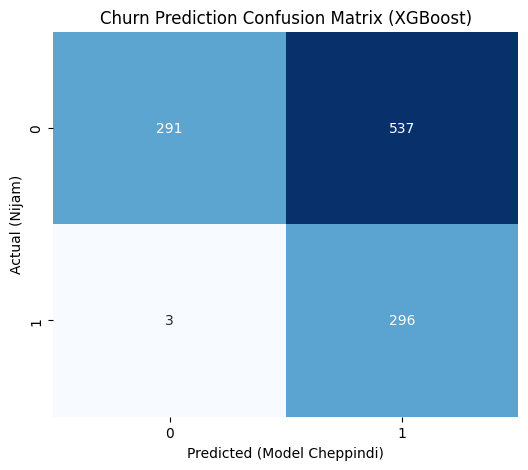

✅ Image 1 Saved: 'churn_confusion_matrix.png'


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# --- 1. Confusion Matrix
plt.figure(figsize=(6, 5))
# Tuned XGBoost (best_xgb_model)
cm = confusion_matrix(y_test, y_pred_xgb_opt)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Churn Prediction Confusion Matrix (XGBoost)')
plt.xlabel('Predicted (Model Cheppindi)')
plt.ylabel('Actual (Nijam)')


plt.savefig('churn_confusion_matrix.png', dpi=300)
plt.show()
print("✅ Image 1 Saved: 'churn_confusion_matrix.png'")



**ROC curve**

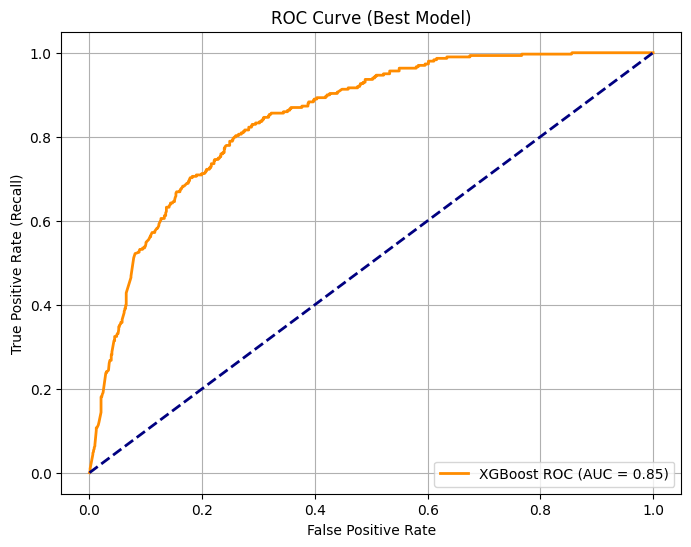

✅ Image 2 Saved: 'churn_roc_curve.png'


In [16]:

plt.figure(figsize=(8, 6))

# ROC  Probabilities
y_prob_best = best_xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #(Random Guess)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve (Best Model)')
plt.legend(loc="lower right")
plt.grid(True)


plt.savefig('churn_roc_curve.png', dpi=300)
plt.show()
print("✅ Image 2 Saved: 'churn_roc_curve.png'")